## Darpa Player 

The darpa player is defined by a Markov Chain Model with N states and the output can be int in the range of 1:M 

My Class attemps to recreate the DARPA Player so we can use it to simulate and run MonteCarlo simulations against our model and see if we can Pass the Hurdle #3 on the DARPA competition 

In [1]:
import random
import numpy as np

print range(10)
p_ = np.random.random(10)
print np.random.choice(range(10),1,p=p_/sum(p_))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1]


In [2]:
class RandomPlayer:
    ''' A Simple class that simulate a Random Player for the #3 Hurdle of the DARPA Competition  '''
    import numpy as np
    
    def normalizeProbs(self,p_):        
        
        if (p_<0).any():
            print "Error", p_
        p_ = [float(i)/sum(p_) for i in p_]            
        return p_
        
    def createProbs(self,L):
        p_ = np.random.random(self.N)
        
        if (p_<0).any():
            print "Error 5", p_
            
        p_ = self.normalizeProbs(p_)                
        
        return p_
        
    def __init__ (self, Max_N, M):
        self._type = "Random"
        self.N = np.random.choice(range(3,Max_N)) ## Random N-states
        self.M = M                               ##  M-outputs
        self.q = np.random.choice(range(self.N)) ## Random current state given N States 
        self.Q = np.zeros(shape= (self.M-1, self.N)) ## Transition Matrix Given Other Player Output
        
        # Iterate all rows 
        for i in range(self.Q.shape[0]-1):
            
            p_ = self.createProbs(self.N)
            self.Q[i,:] = p_ # create row probabilities 
            # Get Row Q[q,:] row q all colums
            # Get Col Q[:,q] all rows q colum
            
        
        # In order to get A -> choice from Q column
    def start(self):
        
        p_ = self.Q[:,self.q]
        p_ = self.normalizeProbs(p_)        
            
        return [np.random.choice(range(1,self.M), p=p_),self.predict()]
        
    def step(self, A):
        
        ## TODO ERROR CASE WHEN A > M 
        
        # Return A
        
        p_ = self.Q[:,self.q]
                  
        p_ = self.normalizeProbs(p_)
        
        D =  np.random.choice(range(1,self.M), p=p_)
        
        # update the state N 
        self.update(D)
        
        return [D,self.predict()]
        
    def update(self, A):
        #print self.Q.shape, A-1
        
        p_ = self.Q[A-1,:]               
            
        p_ = self.normalizeProbs(p_)
        #p_ = p_ / sum(p_)
        
        self.q = np.random.choice(range(self.N), p=p_)
        
        
    def predict(self):
        return np.random.choice(range(self.M)) # Random Guess
        
    def restart(self, Max_N):
        self.__init__(Max_N,self.M)
        return True
        
        
        
        
        

In [3]:
for y in range(10):
    test = RandomPlayer(4,10)
    for i in range(500):
        test.start()


In [4]:

#print test.start()
#print test.N, test.M
print test.step(test.M)

[4, 0]


In [5]:
np.zeros(3)

array([ 0.,  0.,  0.])

In [31]:
class Hurdle_MC:
    ''' Simple Class to Emulate the 3rd hurdle of the DARPA Competition'''
    
    
    
    def normalizeProbs(self,p_):
        
        #p_ = p_ / sum(p_)   
        p_ = [float(i)/sum(p_) for i in p_]
        return p_
        
    
    def __init__ (self, Player_1, Player_2, total_runs, Max_N, Max_M):
        import numpy as np
        import pandas as pd 
        
        self.turns = 300
        self.MaxN = Max_N  ## Variable for Random Player
        self.MaxM = Max_M ## Variable for Random Player
        self.PlayerD = Player_1 # 'DARPA'
        self.PlayerA = Player_2 # 'Us'
        self.BestPlayer = Player_2 ## Save the best player (for intelligent players)
        self.mc_runs = total_runs # Total MonteCarlo runs
        self.score = np.zeros(self.turns) # current score
        self.LastScore = np.ndarray(shape= (total_runs,self.turns)) # Save the score of each run 
        self.BestPlayer = None
        
        
    def _Score(self,A,P,D):
        payoff = 0 
        if A==D:  
            payoff = payoff-12
        if A!=D:
            payoff = payoff+1
        if P==D:
            payoff = payoff+3
            
        return payoff
    
    def one_game(self):
        
        
        self.PlayerD.restart(self.MaxN)
        if self.PlayerA._type == "Random":
            self.PlayerA.restart(self.MaxN)
        else:            
            self.PlayerA.restart()
        
        [A,P] = self.PlayerA.start()
        
        for turn in range(self.turns-1):# All turns but the last turn
            [D,x] = self.PlayerD.step(A) # DARPA Turn with given output A
            self.score[turn] = self._Score(A,P,D)# Score previous turn
            [A,P] = self.PlayerA.step(D) # Make the play for next turn
            
        self.score[self.turns-1] = self._Score(A,P,D)
        
        
        return self.PlayerA
        
    
    def plot_games(self):
        
        import matplotlib.pyplot as plt
        import pandas as pd
        import math 
        %matplotlib inline
        
        # Convert the Scores of each run to DataFrame and get 10 means for ploting
        score_df = pd.DataFrame(self.LastScore).transpose()#[-math.ceil(self.turns)/30:]
        last = np.int32(math.ceil(self.turns/30)) 
        
        score_df = score_df[-last:].cumsum()
        score_df = self.bin_runs(score_df)
        
        #plt.plot(score_df, label=score_df.columns)
        
        
        score_df.plot()        
        l= plt.axhline(y=last*2,xmin=0, xmax=1 ,linewidth=2, color='ForestGreen',label='Threshold')
        plt.ylabel('Score')
        plt.xlabel('Turn')        
        plt.title("Random Player Score over Time (Turns) for M = {0}".format(self.PlayerD.M))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        
    
    def bin_runs(self, df):
        import pandas as pd
        df_avg = pd.DataFrame()
        bins = np.int16(np.round(np.linspace(0,len(df.columns),num=11)))
        
        for i in range(len(bins)-1):
            df_avg[i] = df[df.columns[i:i+1]].mean(axis=1)

        return df_avg
    
    def UpdateBestPlayer(self, Player):
        
        import pandas as pd
        import math 
        
        last = np.int32(math.ceil(self.turns/30)) 
        current_score = self.score[-last:].cumsum()[-1]
        
        if self.BestPlayer == None:
            self.BestPlayer = Player
            self.BestScore = current_score

        else:                        
            if current_score > self.BestScore:
                self.BestPlayer = Player
                self.BestScore = current_score
            
        return True
        
    def simulate(self):
                    
        for ith_game in range(self.mc_runs):
            #print ith_game
            #M_ = np.random.choice(range(3,self.MaxM)) ## Random M-channels
            ith_Player = self.one_game()            
            self.LastScore[ith_game] = self.score
            self.UpdateBestPlayer(ith_Player)
            
        self.plot_games()    
        
        
        
        
        
        
        

[3, 3]
[3, 2]
Wall time: 1.64 s


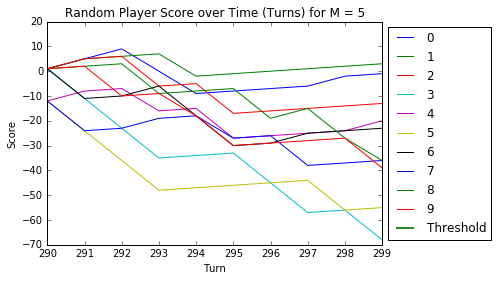

In [32]:
P1 = RandomPlayer(4,5)
P2 = RandomPlayer(7,5)

print P1.step(3)
print P2.step(3)
test = Hurdle_MC(P1,P2,30,10,10)

%time test.simulate()

In [34]:
test.BestPlayer

<__main__.RandomPlayer instance at 0x000000000751EA08>